In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import shutil

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, ColorJitter, Compose, Normalize

from torch import nn
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.nn import BatchNorm2d
from torch.nn import LSTM
import torch.nn.functional as F

In [3]:
img_dir = './samples/'
seed = 42

## Prepare data

In [4]:
class Alphabet(object):
    def __init__(self):
        self.symbol2idx = {}
        self.idx2symbol = []
        self._len = 0
        
    def add_symbol(self, s):
        if s not in self.symbol2idx:
            self.idx2symbol.append(s)
            self.symbol2idx[s] = self._len
            self._len += 1
    
    def __len__(self):
        return self._len

In [5]:
class Corpus(object):
    def __init__(self, folder_path):
        self.dictionary = Alphabet()
        self.make_alphabet(folder_path)
        # self.text = self.tokenize(path)
        
    def make_alphabet(self, folder_path):
        assert os.path.exists(folder_path)
        # Add symbols to the dictionary
        for _, _, files in os.walk(folder_path):
            for file_name in files:
                file_name = file_name.split('.')[0]
                for symbol in file_name:
                    self.dictionary.add_symbol(symbol)

    def tokenize(self, label):
        """Tokenize file_name."""
        ids = torch.zeros([len(label), len(self.dictionary)], dtype=torch.float32)
        for pos, symbol in enumerate(label):
            ids[pos, self.dictionary.symbol2idx[symbol]] = 1.
        return ids

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, corpus, transform=None, target_transform=None):
        self.img_labels = []
        for _, _, files in os.walk(img_dir):
            for file_ in files:
                self.img_labels.append(file_)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.corpus = corpus

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        filename = self.img_labels[idx]
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path).convert('RGB')
        label = self.corpus.tokenize(filename.split('.')[0])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
all_files = []
for _, _, files in os.walk(img_dir):
    for file_ in files:
        all_files.append(file_)
        
random.shuffle(all_files)
border = int(0.8*len(all_files))
train_files = all_files[:border]
test_files = all_files[border:]

In [8]:
train_data_dir = 'data/train/'
test_data_dir = 'data/test/'

if not os.path.exists(train_data_dir):
    os.makedirs(train_data_dir)
    for file in train_files:
        shutil.copy(os.path.join(img_dir, file), train_data_dir)

if not os.path.exists(test_data_dir):
    os.makedirs(test_data_dir)
    for file in test_files:
        shutil.copy(os.path.join(img_dir, file), test_data_dir)

In [9]:
corpus = Corpus(train_data_dir)

train_dataset = CustomImageDataset(img_dir=train_data_dir,
                                   corpus=corpus,
                                   transform=Compose([
                                            ColorJitter(),
                                            ToTensor(),
                                            Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                                   ]))

test_dataset = CustomImageDataset(img_dir=test_data_dir,
                                  corpus=corpus,
                                  transform=Compose([
                                            ToTensor(),
                                            Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                                 ]))

In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

## Create Model

In [11]:
class RNN(torch.nn.Module):
    def __init__(self, class_num, hidden_unit):
        super(RNN, self).__init__()
        self.Bidirectional_LSTM1 = torch.nn.LSTM(512, hidden_unit, bidirectional=True)
        self.embedding1 = torch.nn.Linear(hidden_unit * 2, 512)
        self.Bidirectional_LSTM2 = torch.nn.LSTM(512, hidden_unit, bidirectional=True)
        self.embedding2 = torch.nn.Linear(hidden_unit * 2, class_num)

    def forward(self, x):
        x = self.Bidirectional_LSTM1(x)   # LSTM output: output, (h_n, c_n)
        T, b, h = x[0].size()   # x[0]: (seq_len, batch, num_directions * hidden_size)
        x = self.embedding1(x[0].view(T * b, h))  # pytorch view() reshape as [T * b, nOut]
        x = x.view(T, b, -1)  # [7, b, 512]
        x = self.Bidirectional_LSTM2(x)
        T, b, h = x[0].size()
        x = self.embedding2(x[0].view(T * b, h))
        x = x.view(T, b, -1)
        return x  # [16,b,class_num]


In [12]:
class CapchaNet(Module):
    def __init__(self, alphabet_len):
        super(CapchaNet, self).__init__()
        
        self.conv1 = Conv2d(3, 16, (3, 3), stride = (1, 2)) # 99x48
        self.bn1 = BatchNorm2d(16)
        self.conv2 = Conv2d(16, 32, (3, 3), stride=2) # 50x24
        self.bn2 = BatchNorm2d(32)
        self.conv3 = Conv2d(32, 64, (3, 3) , stride=2) # 26x12
        self.bn3 = BatchNorm2d(64)
        self.conv4 = Conv2d(64, 128, (3, 3) , stride=2) # 13x6
        self.bn4 = BatchNorm2d(128)
        self.conv5 = Conv2d(128, 256, (3, 3)) # 9x3
        self.bn5 = BatchNorm2d(256)
        self.conv6 = Conv2d(256, 512, (3, 5)) # bx5x1x512
        self.bn6 = BatchNorm2d(512)
        # self.glob_pool = AdaptiveAvgPool2d((1,1)) 
        self.rnn = RNN(alphabet_len, 512)
        
    def conv_block(self, in_cnannels, out_shannels, kernel=(3, 3), stride=True, bn=True):
        pass

    
    def forward(self, x):
        
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.bn6(F.relu(self.conv6(x)))
        # x = self.glob_pool(x)
        #x = flatten(x, start_dim=1)
        
        b, c, h, w = x.size()
        # print(x.size()): b,c,h,w
        assert h == 1   # "the height of conv must be 1"
        
        x = x.squeeze(2)  # remove h dimension, b *512 * width
        x = x.permute(2, 0, 1)  # [w, b, c] = [seq_len, batch, input_size]
        x = self.rnn(x)
        x = x.permute(1, 0, 2)
        output = F.log_softmax(x, dim=2) 
        return output

## Train

In [13]:
import string
import math

ntokens = len(train_dataset.corpus.dictionary)
model = CapchaNet(ntokens)
criterion = nn.CrossEntropyLoss()
grad_clip = 0.1
log_interval = 10
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
def train(model):
    
    model.train()
    total_loss = 0
    total_val_loss = 0
    for batch, (data, targets) in enumerate(train_loader):
        
        output = model(data)
        
        optim.zero_grad()
        
        loss = criterion(output, targets)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optim.step()
        total_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        for data, targets in test_loader:
            preds = model(data)
            val_loss = criterion(preds, targets)
            total_val_loss += val_loss.item()
    
    total_loss /= len(train_loader)
    total_val_loss /= len(test_loader)
    print('epoch {:3d} | lr {:02.3f} | train loss {:5.4f} | test loss {:5.4f}'.format(
                epoch + 1, lr, total_loss, total_val_loss))
    return total_loss, total_val_loss

In [15]:
loss_curve_train, loss_curve_test = [], []

In [16]:
for epoch in range(50):
    train_loss, test_loss = train(model)
    loss_curve_train.append(train_loss)
    loss_curve_test.append(test_loss)

epoch   1 | lr 0.001 | train loss 0.3614 | test loss 0.4502
epoch   2 | lr 0.001 | train loss 0.2083 | test loss 0.4237
epoch   3 | lr 0.001 | train loss 0.1247 | test loss 0.1794
epoch   4 | lr 0.001 | train loss 0.0834 | test loss 0.1436
epoch   5 | lr 0.001 | train loss 0.0666 | test loss 0.1141
epoch   6 | lr 0.001 | train loss 0.0627 | test loss 0.0967
epoch   7 | lr 0.001 | train loss 0.0575 | test loss 0.1078
epoch   8 | lr 0.001 | train loss 0.0530 | test loss 0.1009
epoch   9 | lr 0.001 | train loss 0.0484 | test loss 0.1053
epoch  10 | lr 0.001 | train loss 0.0472 | test loss 0.0864
epoch  11 | lr 0.001 | train loss 0.0451 | test loss 0.0772
epoch  12 | lr 0.001 | train loss 0.0441 | test loss 0.0955
epoch  13 | lr 0.001 | train loss 0.0453 | test loss 0.0935
epoch  14 | lr 0.001 | train loss 0.0439 | test loss 0.0984
epoch  15 | lr 0.001 | train loss 0.0448 | test loss 0.1147
epoch  16 | lr 0.001 | train loss 0.0452 | test loss 0.2041
epoch  17 | lr 0.001 | train loss 0.0496

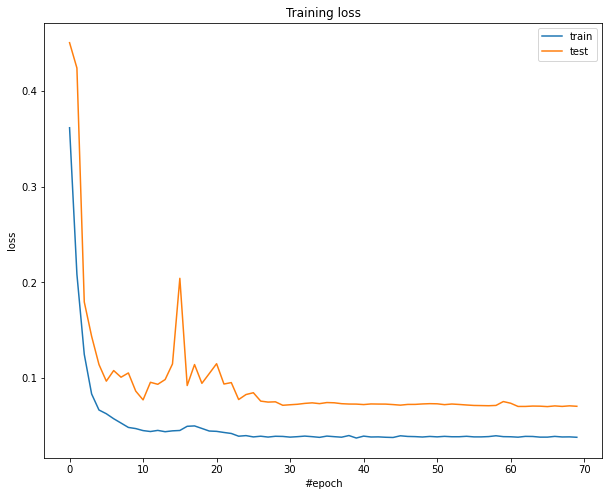

In [17]:
# Visualize loss
plt.figure(figsize=(10, 8))
    
plt.title("Training loss")
plt.xlabel("#epoch")
plt.ylabel("loss")

plt.plot(loss_curve_train, label='train')
plt.plot(loss_curve_test, label='test')


#plt.yscale('log',base=2)
plt.legend()
plt.show()